<a href="https://colab.research.google.com/github/isabelvrielink/Paralinguistic-feature-extraction-for-audio-deepfake-detection/blob/main/Final_model%2C_coding_part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Final model run

In [ ]:
# Libraries
!pip install --upgrade kagglehub
!pip install matplotlib-venn
!apt-get -qq install -y libfluidsynth1
!pip install tensorflow-hub
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
!apt-get -qq install -y graphviz && pip install pydot
!pip install cartopy
!pip install pydub
!pip install librosa
!pip install scikit-learn
!pip install scikit-plot matplotlib

^C
^C
Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.6.0-1ubuntu1_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.6.0-1ubuntu1) ...
Setting up libarchive-dev:amd64 (3.6.0-1ubuntu1) ...
Processing triggers for man-db (2.10.2-1) ...
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 7.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for libarchive
  Running setup.py clean for libarchive
Failed to build libarchive
ERROR: Could not build wheels for libarchive, which is required to install pyproject.toml-based projects
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 35.2 M

In [ ]:
# Import modules
import kagglehub
import pydot
import cartopy
import tensorflow as tf
import tensorflow_hub as hub
import librosa
import numpy as np
import pandas as pd
import os
from pydub import AudioSegment
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, accuracy_score, precision_score, recall_score, f1_score


In [ ]:
# Mount drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# define input dataframes (embedding - label pairs) by merging the 3 dataframes of train, val, test to 1 dataset
# and split 70/20/10 train/val/test
# dataframes are generated in coding part 2
# TRILLsson embeddings from the dataframe are generated in part 1 & 2

df_train = pd.read_pickle('/path/to/Dataframes/df_train.pkl')
df_dev = pd.read_pickle('/path/to/Dataframes/df_dev.pkl')
df_eval = pd.read_pickle('/path/to/Dataframes/df_eval.pkl')

df_combined = pd.concat([df_train, df_dev, df_eval])


In [ ]:
# prepare logistic regression,
# shuffle the input data so the 80k is balanced again
# normalize

df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)
train, validation, test = np.split(df_combined, [int(.7*len(df_combined)), int(.9*len(df_combined))])

df_train, df_validation, df_test = train, validation, test

X_train = np.stack(df_train['embedding'].values)
y_train = df_train['label'].values
X_val = np.stack(df_validation['embedding'].values)
y_val = df_validation['label'].values
X_test = np.stack(df_test['embedding'].values)
y_test = df_test['label'].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# train logistic regression model

# Logistic regression architecture
logreg = LogisticRegression(max_iter=10000)

# Training the model
logreg.fit(X_train_scaled, y_train)

# Predict on the validation and test data
y_val_pred = logreg.predict(X_val_scaled)
y_test_pred = logreg.predict(X_test_scaled)

In [ ]:
# compute the Equal Error Rate (EER)
# https://stackoverflow.com/questions/28339746/equal-error-rate-in-python

import numpy as np
from sklearn.metrics import roc_curve

y_scores = logreg.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, threshold = roc_curve(y_test, y_scores, pos_label=1)
fnr = 1 - tpr
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print("EER threshold:", eer_threshold)
print("EER: ", EER)


EER threshold: 0.07269242431135127
EER:  0.035500487261589865


In [ ]:
# compute performance metrics
# Accuracy,  precision, recall, F1-score

from sklearn import metrics

accuracy = round(metrics.accuracy_score(y_val, y_val_pred), 5)
recall = round(metrics.recall_score(y_val, y_val_pred), 5)
precision = round(metrics.precision_score(y_val, y_val_pred), 5)
f1 = round(metrics.f1_score(y_val, y_val_pred), 5)

print("Evaluation metrics for the validation set:")
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1)

accuracy_test = round(metrics.accuracy_score(y_test, y_test_pred), 5)
recall_test = round(metrics.recall_score(y_test, y_test_pred), 5)
precision_test = round(metrics.precision_score(y_test, y_test_pred), 5)
f1_test = round(metrics.f1_score(y_test, y_test_pred), 5)

print("\nEvaluation metrics for the test set:")
print("Accuracy:", accuracy_test)
print("Recall:", recall_test)
print("Precision:", precision_test)
print("F1-score:", f1_test)


Evaluation metrics for the validation set:
Accuracy: 0.97642
Recall: 0.88054
Precision: 0.89674
F1-score: 0.88856

Evaluation metrics for the test set:
Accuracy: 0.97822
Recall: 0.88732
Precision: 0.90539
F1-score: 0.89627


In [ ]:
y_test_proba = logreg.predict_proba(X_test_scaled)


In [ ]:
from sklearn.metrics import roc_curve, auc

probas_positive_class = y_test_proba[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probas_positive_class)
roc_auc = auc(fpr, tpr)

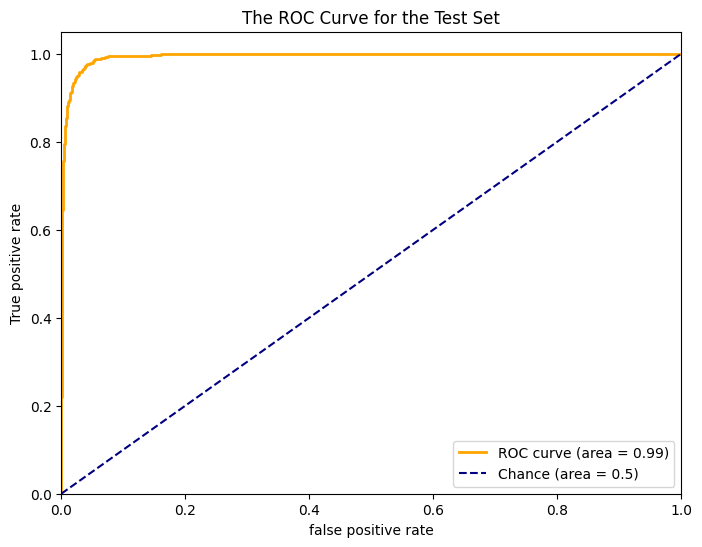

In [ ]:
# Code by https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Chance (area = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('True positive rate')
plt.title('The ROC Curve for the Test Set')
plt.legend(loc="lower right")
plt.show()

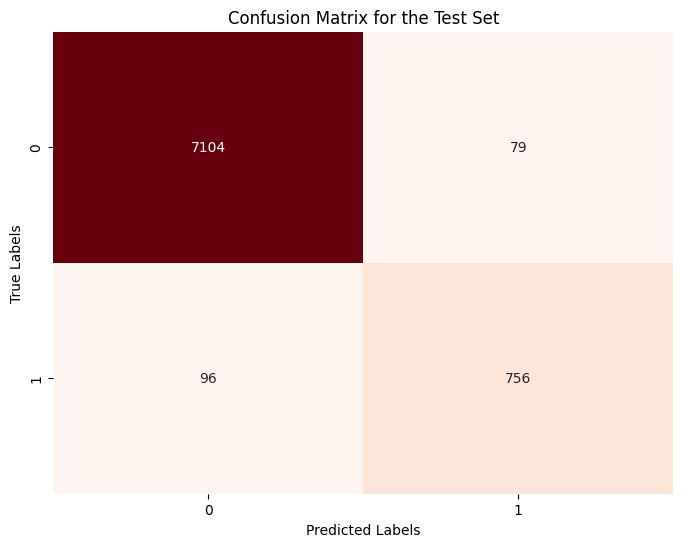

In [ ]:
# Code by https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

conf_matrix_test = metrics.confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap='Reds', cbar=False)
plt.title('Confusion Matrix for the Test Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()